# Quantum K-Nearest Neighbors: Utilizing QRAM and SWAP-Test Techniques for Enhanced Performance


## Classical algorithm

The classical K-NN classification algorithm, extensively utilized in supervised learning, relies on two datasets: a training set containing labeled samples and a test set consisting of unlabeled ones. To classify each test sample, the algorithm employs a similarity metric, typically a distance metric in feature space.


the classical algorithm is shown as an image and pseudocode:


<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Classical K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set. <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the training set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Compute the distance between the test event and training event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Find the K nearest neighbors to the test event.<br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure1.png" alt="example of K-NN" style=" height: 233px; width:621px;  display: block; margin-left: auto;   margin-right: auto;"  />

## Quantum proposal

### Dependencies 


This quantum algorithm uses qiskit, numpy, skelearn  and seaborn as dependencies to run the cide.

In [1]:
# import sklearn to load the iris dataset and split the dataset in train and test model, and the metric confusion matrix
from sklearn import datasets
from sklearn.model_selection import train_test_split

# import pandas to use seaborn plots as hue parameter
import pandas as pd

# import seaborn to plot the iris dataset
import seaborn as sns

# import numpy for postprocessing to find the k-nn label
import numpy as np

# import qiskit minimal methods to use quantum circuit and use qubits as the classical bits
from qiskit import QuantumCircuit,QuantumRegister,ClassicalRegister,transpile
from qiskit.circuit.library.standard_gates import RYGate,RZGate

from qknn.functions import index_positions, diffuser, qram, oracle_st, qknn, qknn_experiments

# Dataset

Obtained  iris dataset from sklearn using dataset module. The iris dataset is used, which has 3 classes: **Iris-setosa**,**Iris-versicolor**,**Iris-virginica**, each with 50 instances, resulting in a total of 150.


In [2]:
iris = datasets.load_iris()

This dataset plot using Seaborn module, a dataframe is required to read the variables, denoted as 'var1', 'var2', 'var3', and 'var4', along with the 'class' for color differentiation. Additionally, the chosen color palette is 'Paired'. 

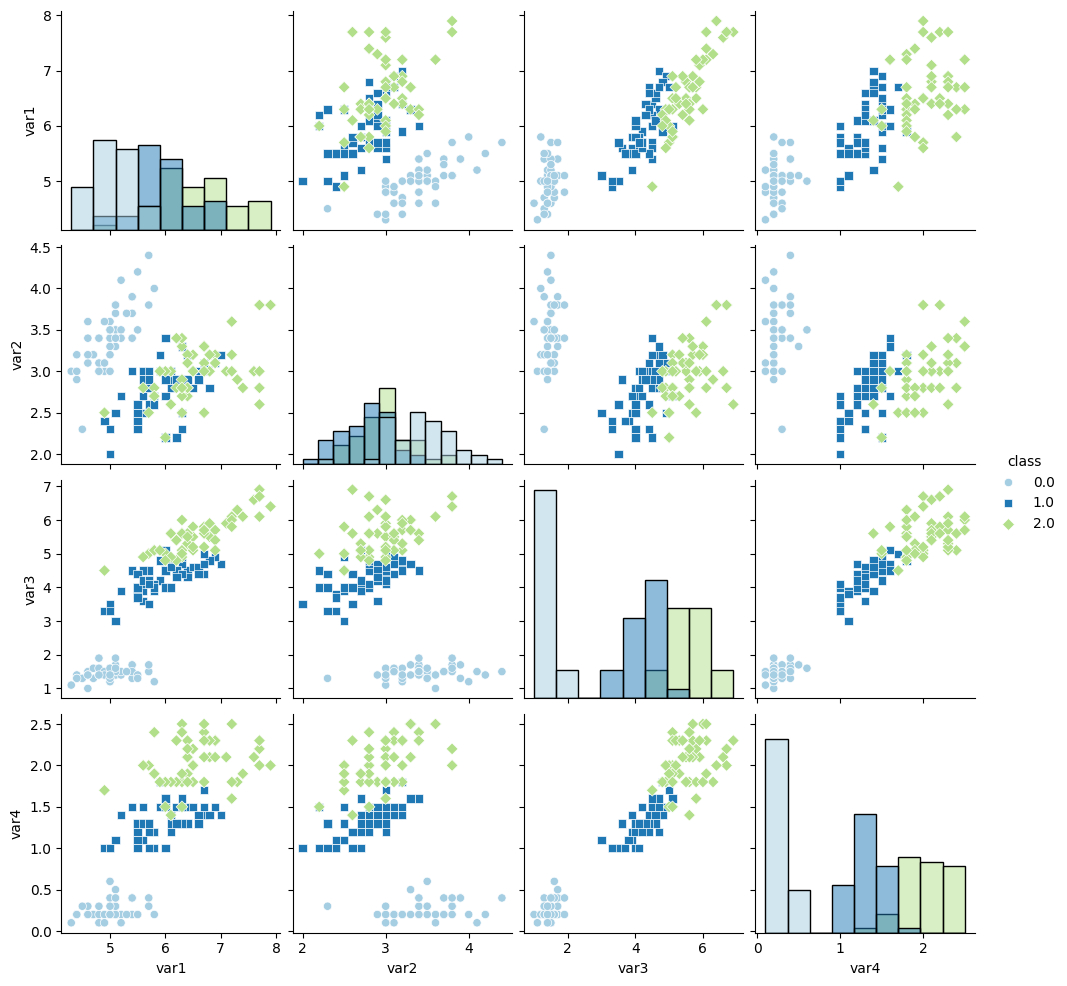

In [3]:
df_iris = pd.DataFrame(np.append(iris['data'],np.atleast_2d(iris['target']).T, axis=1))
df_iris.columns =['var1', 'var2', 'var3', 'var4',"class"]
sns.pairplot(df_iris,hue="class", diag_kind="hist", markers=["o", "s", "D"], palette="Paired")

The hold-out method is used, with a split of 70% for the training set and 30% for the test set.

In [4]:
x_train, x_test, y_train, y_test =train_test_split(iris['data'], iris['target'], train_size=0.7, test_size=0.3, random_state=13)

In [5]:
print("Number of original training examples:", len(x_train))
print("Number of original test examples:", len(x_test))

Number of original training examples: 105
Number of original test examples: 45


# The quantum algorithm

The QK-NN is based on three critical components: data storage in QRAM, the similarity metric from the SWAP-Test quantum circuit, and grouping both of those to allow Grover's algorithm to increase the probability of selecting states with higher similarity as shown in the following Pseudocode and Figure

<div style="background-color:#E2E2E2; padding:10px 0;font-family:monospace;">
<font color = "blue"><b>Quantum K-NN</b></font><br>
    &nbsp;&nbsp;&nbsp;&nbsp; Designate a labeled training set and an unlabeled test set.<br> 
    &nbsp;&nbsp;&nbsp;&nbsp; Apply angle encoding to the features of both datasets <br> 
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>for </b></font>Each event in the test set <font color = "#ff0000ff"><b></b>do</font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Load the training set into QRAM. <br>
    &nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;&nbsp;  Initialize the oracle qubit to the state $|-\rangle$ <br>
    &nbsp;&nbsp;&nbsp;&nbsp; <font color = "#ff0000ff"><b>end for</b></font><br>   
    &nbsp;&nbsp;&nbsp;&nbsp; The class with the highest number of nearest neighbors is assigned to the test event.<br>
</div>

<img src="images/qknn_figure7.png">

#### initial variables for  a example

In [6]:
# size of the QRAM with 4 cells |00>, |01>, |10>, |11>
size_QRAM = 2

# lenght of the feautres of the QRAM
features = len(x_train[0])

##### Integer to binary

The first method using is generate a function to convert a integer value i na bin representation to qiskit, this  works to generate the control qubits needed for the QRAM

For example, the number 4 convert in 100, but the index position in a QRAM is 2 for the format q0q1q2, where q2 is  the position.

In [7]:
index_positions(4)

[2]

#### The diffuser

Is a quantum circuit used in Grover's algorithm that do a reflection operation to consider in this algorithm only the train state more similar with  the test set's instance

For example a diffuser of 3 qubits where using a mcx gate changed to mcz  with the equivalence HXH = Z.

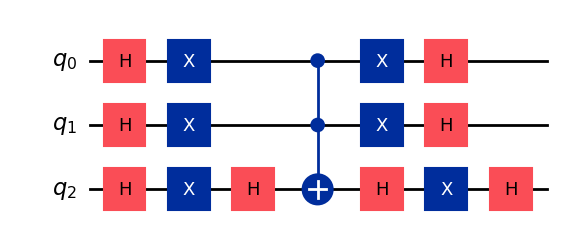

In [8]:
nqubits = 3
def example_diffuser(nqubits:int):
    qc_d = QuantumCircuit(nqubits)
    qc_d.append(diffuser(nqubits),range(nqubits))
    return qc_d
example_diffuser(nqubits).decompose().draw("mpl")

#### The QRAM and QRAM$^{\dagger}$ 


This is a method using a MCX to save the train set, the size must be $2^m$, $m$ is the number of qubits address. a And save the information in $n$ qubits features· 

For example a QRAM of 2 qubits address and the first four elements of iris train set.

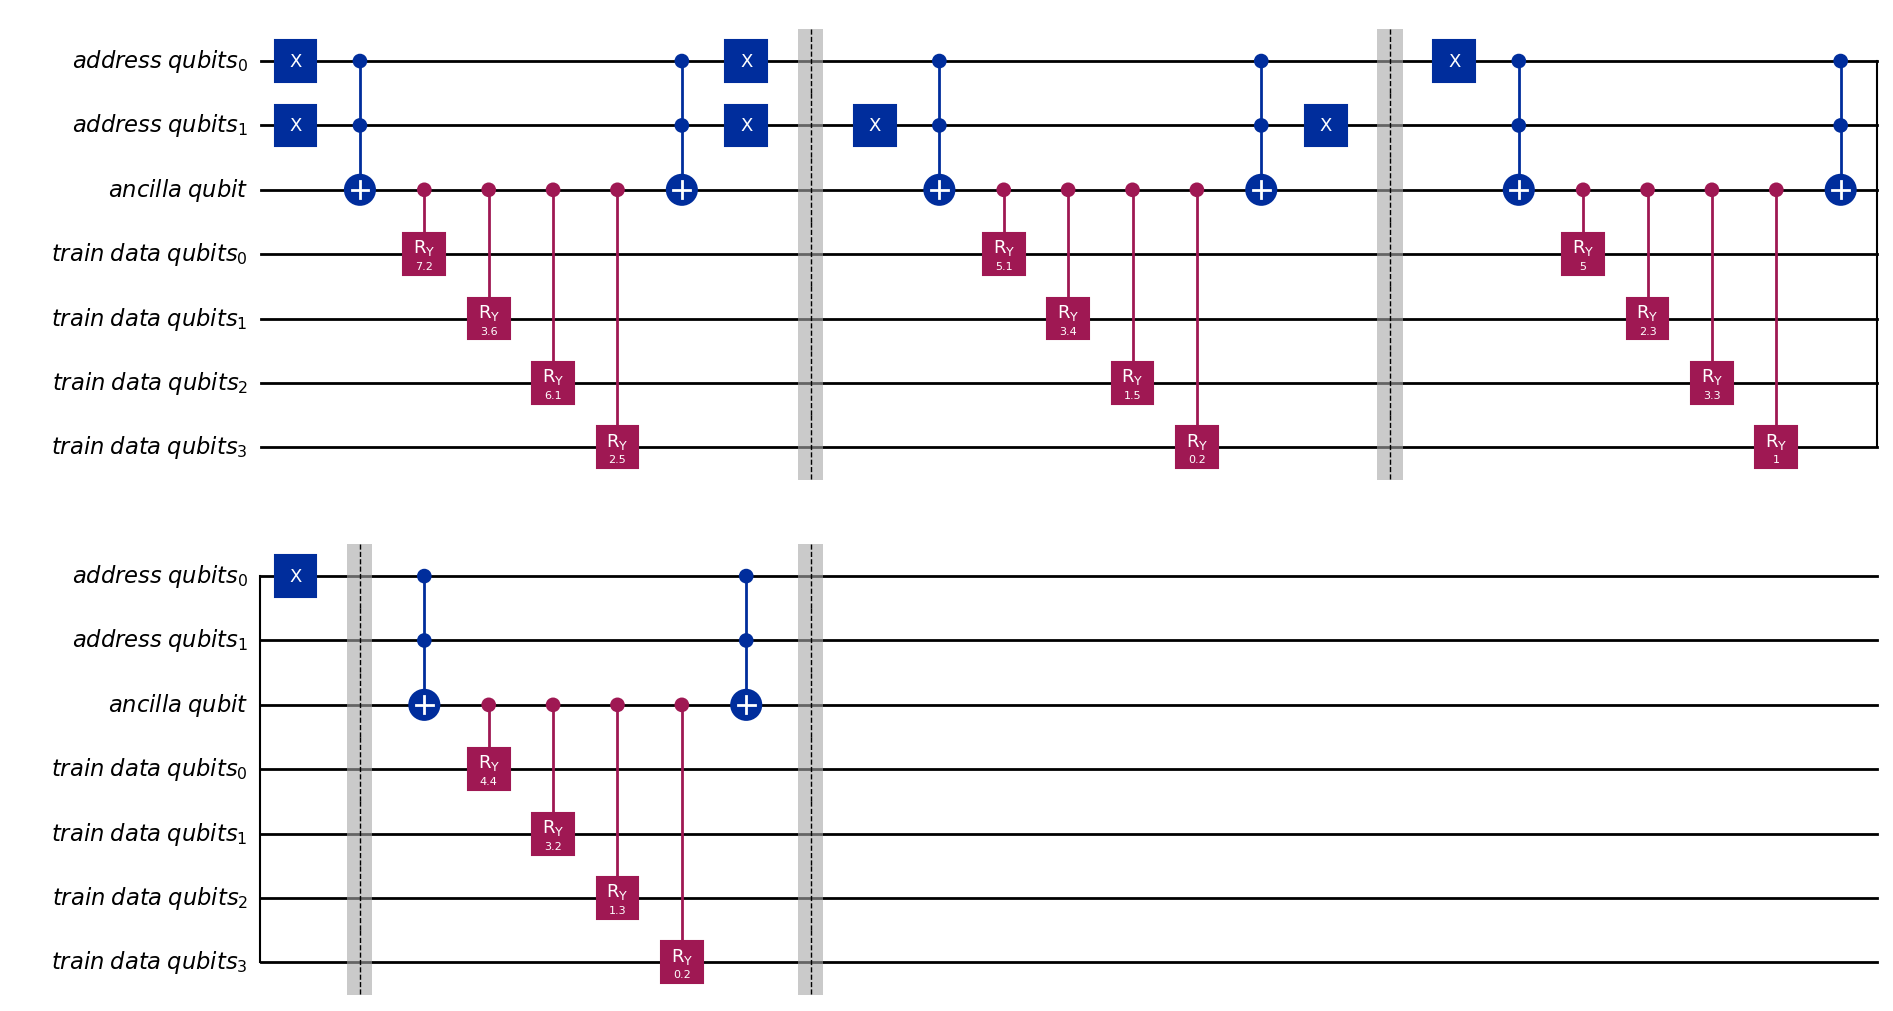

In [9]:
qram(size_QRAM,features,x_train[:4],RYGate).draw("mpl")

In [10]:
type(qram(size_QRAM,features,x_train[:4],RYGate))

qiskit.circuit.quantumcircuit.QuantumCircuit

For example a QRAM$^{\dagger}$ of 2 qubits address and the first four elements of iris train set using the qiskit method **inverse()**.

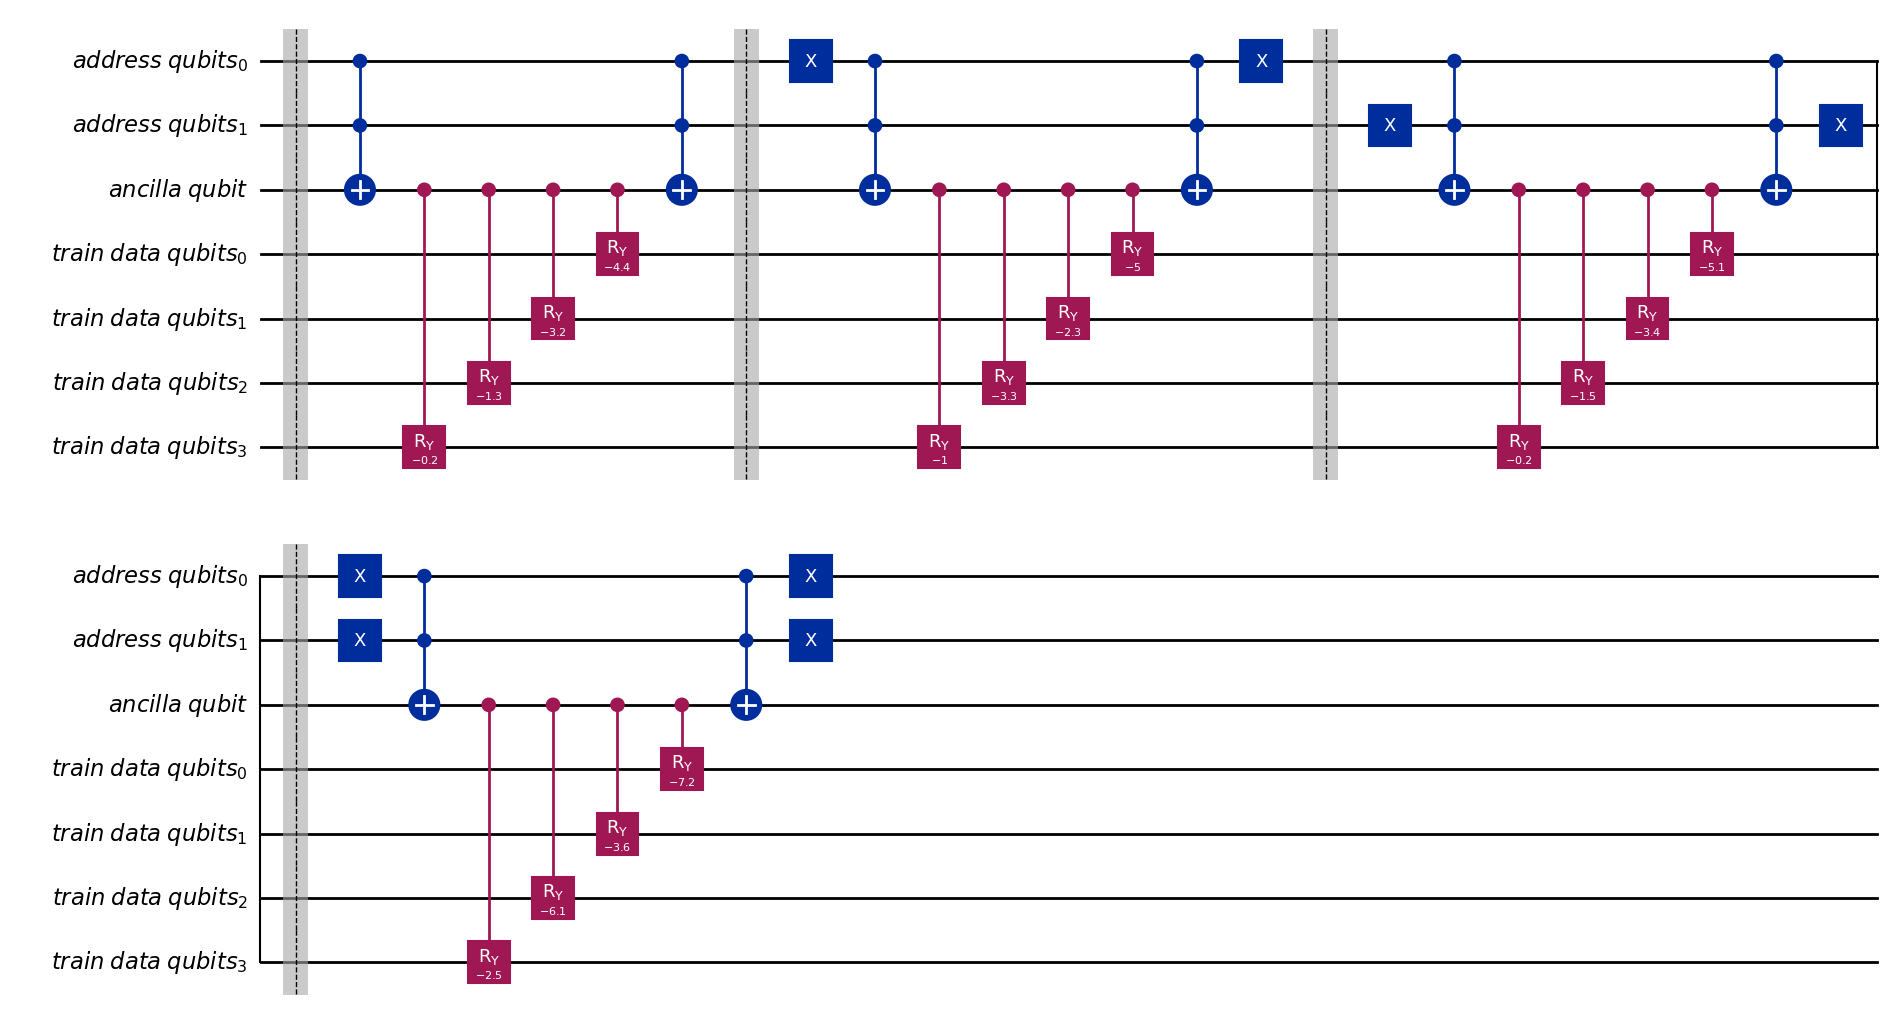

In [11]:
qram(size_QRAM,features,x_train[:4]).inverse().draw("mpl")

#### Oracle


Describes the oracle to check the similar state between the train set and the instance of the test set

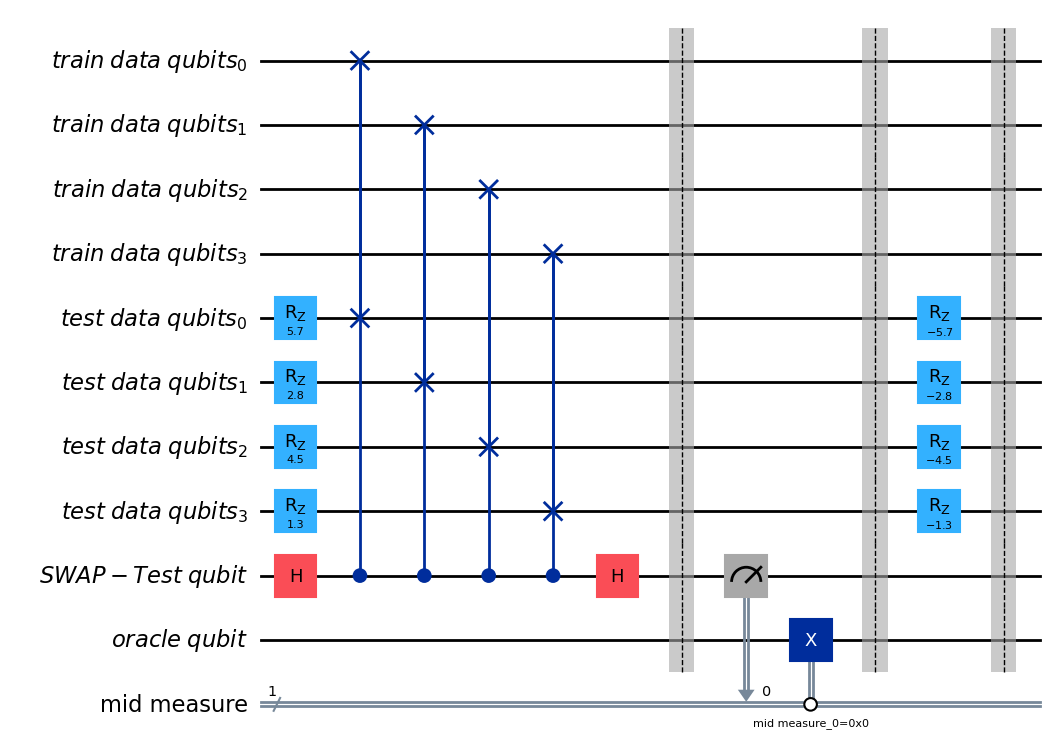

In [12]:
oracle_st(features,x_test[0],RZGate).draw("mpl")

#### Integrate all in a QK-NN quantum circuit

Using the previous function and the diagram to design the Quantum Circuit added the SWAP-Test with intermediate measurement that is activate when is the value 0.

Example with 2 qubits of the QK-NN of the first 4 features.

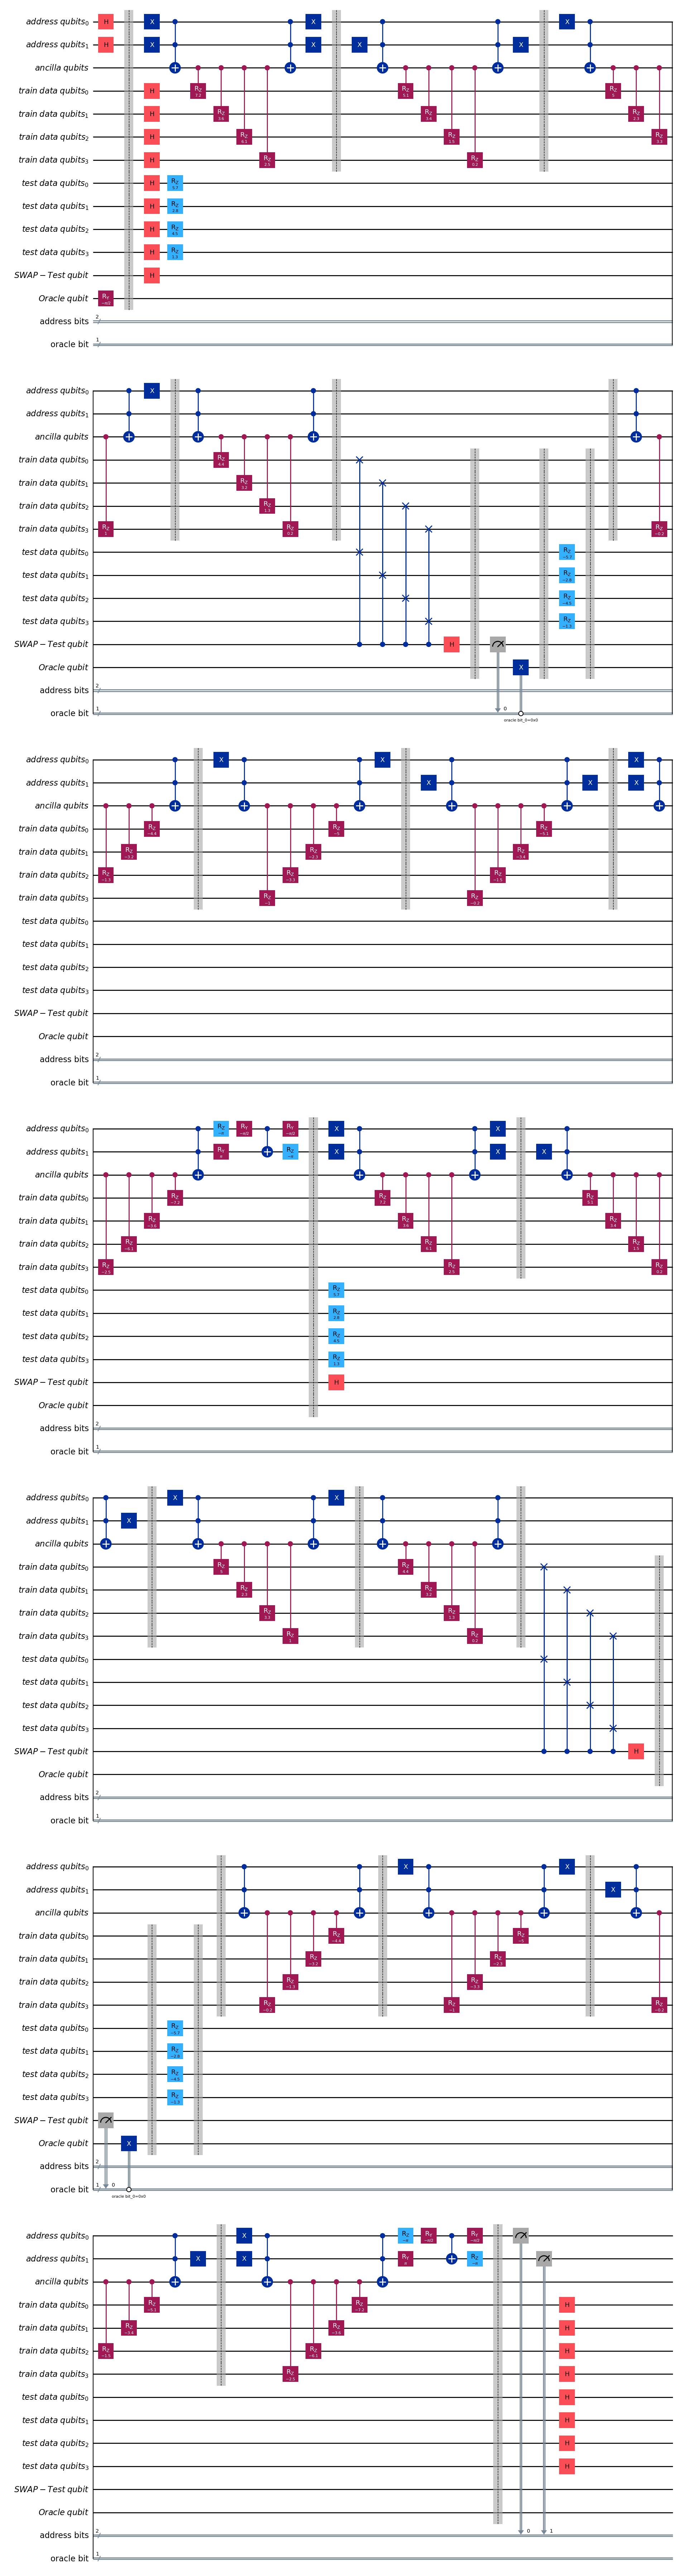

In [13]:
max_trials = 2
transpile(qknn(x_test[0], x_train,size_QRAM,features,max_trials,"rz"), basis_gates=[ 'cswap','cry','crz', 'barrier', 'h', 'measure', 'ccx', 'x', 'reset', 'rz', 'ry', 'snapshot', 'cx', 'delay']).draw("mpl")

### Experiments

Experiments of the QK-NN with size of QRAM of 8, 16, 32, 64, and 128 cells of memory.

###  Results

#### RY

([84.44444444444444, 82.22222222222221, 84.44444444444444, 84.44444444444444, 84.44444444444444, 84.44444444444444, 82.22222222222221, 82.22222222222221, 82.22222222222221, 82.22222222222221], [], [], [], [])
The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 83.33 +/- 1.11.


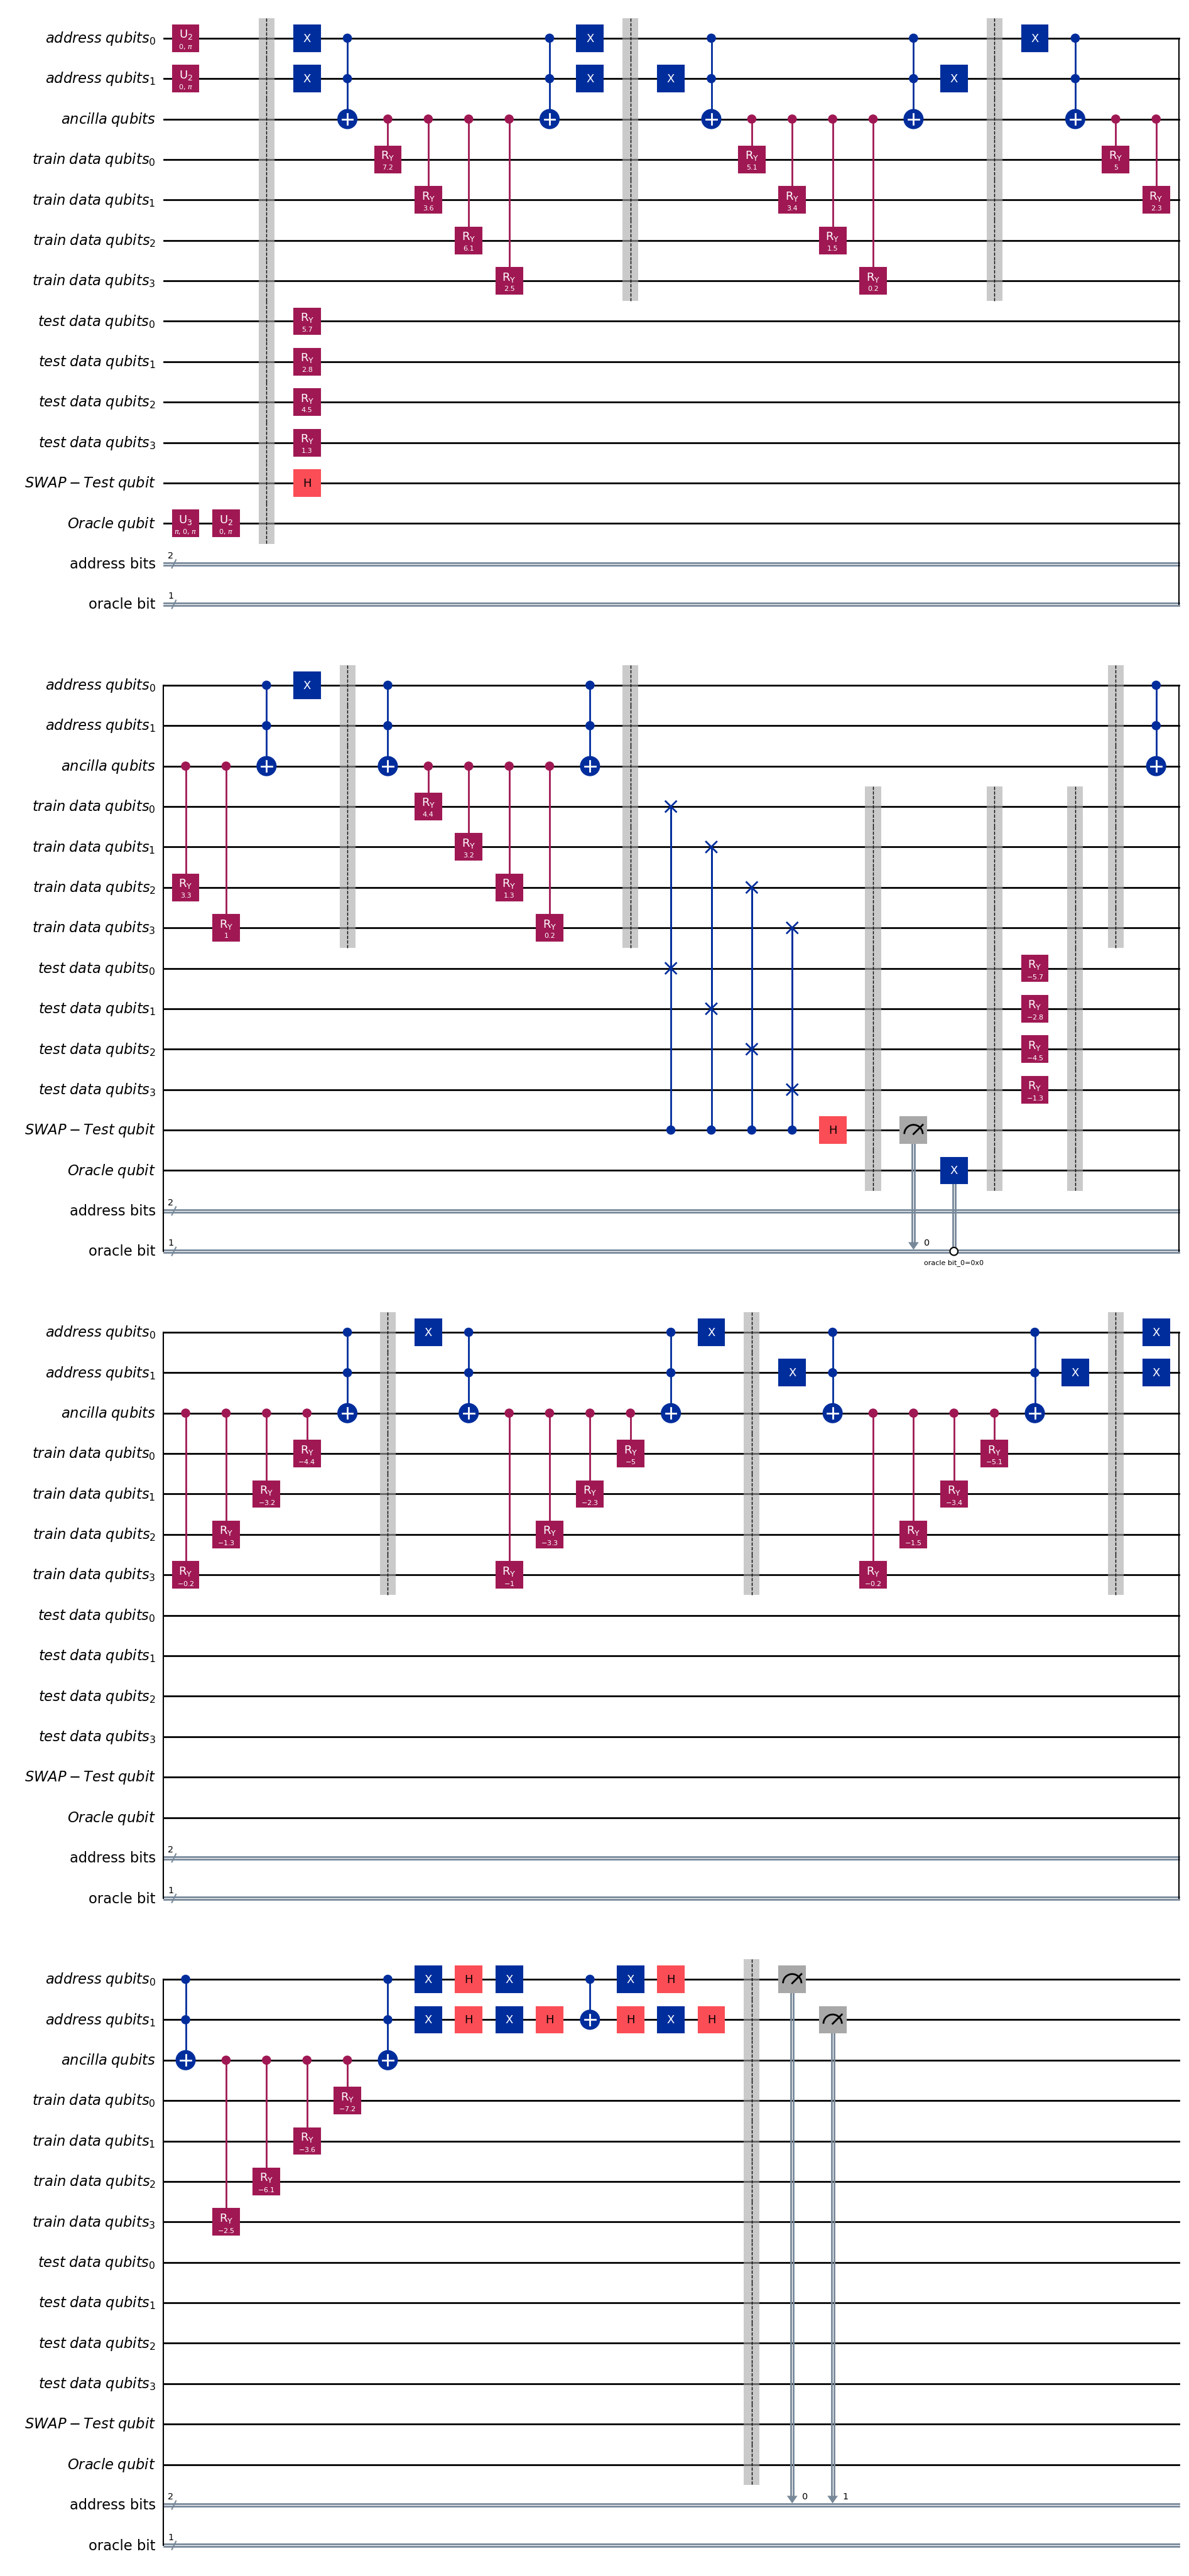

In [14]:
experiment_size = 10
min_QRAM = 3
max_QRAM = 4
qknn_e = qknn_experiments(
    x_test=x_test,
    x_train=x_train,
    y_test=y_test,
    y_train=y_train,
    features=4,
    min_QRAM=min_QRAM,
    max_QRAM=max_QRAM,
    max_trials=1,
    rotation="ry",
    experiment_size=experiment_size)

print(qknn_e.experiments_knn(k=1))
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")

#### RZ

([80.0, 82.22222222222221, 84.44444444444444, 84.44444444444444, 84.44444444444444, 84.44444444444444, 84.44444444444444, 84.44444444444444, 82.22222222222221, 86.66666666666667], [], [], [], [])
The MAE value of each size is 
MAE of  QRAM of size 8 cells of memory with 83.78 +/- 1.38.


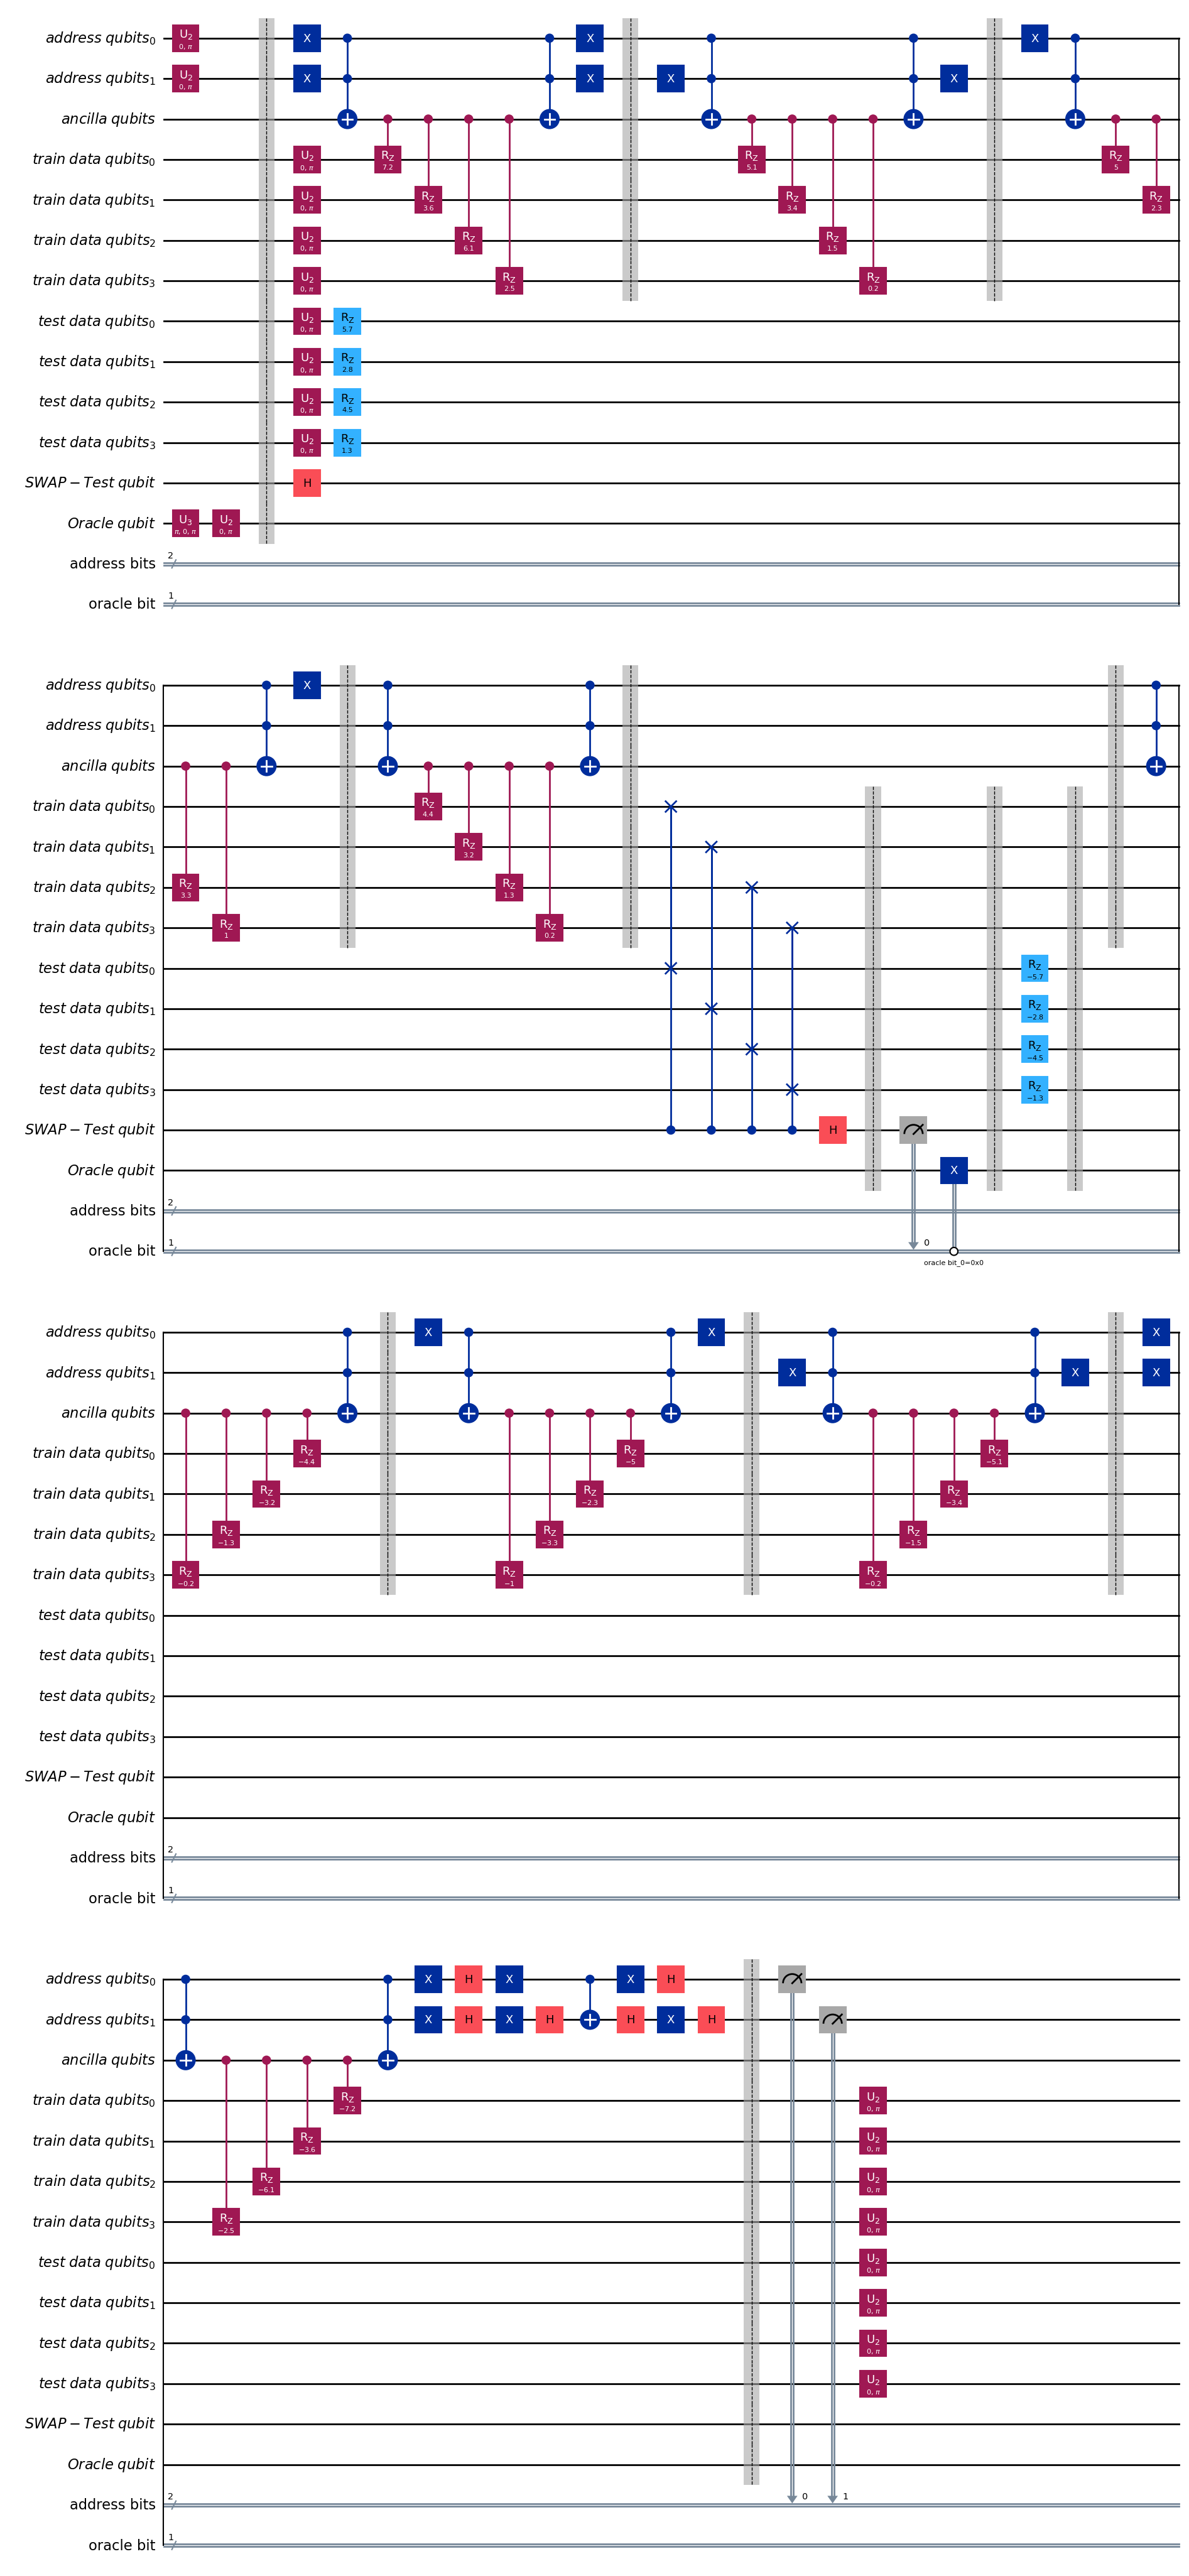

In [15]:
experiment_size = 10
min_QRAM = 3
max_QRAM = 4
qknn_e = qknn_experiments(
    x_test=x_test,
    x_train=x_train,
    y_test=y_test,
    y_train=y_train,
    features=4,
    min_QRAM=min_QRAM,
    max_QRAM=max_QRAM,
    max_trials=1,
    rotation="rz",
    experiment_size=experiment_size)

print(qknn_e.experiments_knn(k=1))
qknn_e.print_results()
qknn_e.draw_qknn(0).decompose().draw("mpl")